# Roget's Thesaurus vs. LLM: Directed Knowledge Graphs and Hallucination Stress Test

**Author:** Moses Boudourides  
**Date:** February 2026

---

This notebook constructs **directed knowledge graphs** for both the 1911 Roget's Thesaurus and its LLM reconstruction (`gpt-4.1-mini`), then applies network-analytic diagnostics — centrality analysis, community detection, and graph comparison — as a *hallucination stress test*, following the methodology of Boudourides (2025).

## 1. Imports and Configuration

In [1]:
import os, pickle, json, re, warnings
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import community as community_louvain  # python-louvain
from pyvis.network import Network
from IPython.display import IFrame, display, HTML
warnings.filterwarnings('ignore')

# ── Paths ──────────────────────────────────────────────────────────────────
ROGET_PKL   = 'cache/roget_parsed.pkl'
LLM_PKL     = 'cache/llm_responses.pkl'
OUT_DIR     = 'kg_output'
os.makedirs(OUT_DIR, exist_ok=True)

# ── Fields used as term lists ───────────────────────────────────────────────
TERM_FIELDS = ['noun_list', 'verb_list', 'adjective_list', 'adverb_list']
FIELD_EDGE  = {
    'noun_list':      'HAS_NOUN',
    'verb_list':      'HAS_VERB',
    'adjective_list': 'HAS_ADJ',
    'adverb_list':    'HAS_ADV',
}

## 2. Load Data

We load the 30-Head sample from both the parsed Roget's Thesaurus and the LLM reconstruction cache. The Roget data is filtered to the same 30 Heads that were queried from the LLM, so the two graphs are directly comparable.

In [2]:
# Load full Roget parse
with open(ROGET_PKL, 'rb') as f:
    roget_all = pickle.load(f)

# Load LLM responses
with open(LLM_PKL, 'rb') as f:
    llm_all = pickle.load(f)

# Build lookup: lower-stripped head_name -> roget entry
roget_lookup = {r['head_name'].lower().strip(): r for r in roget_all}

# Filter Roget to the 30 sampled heads
llm_keys = [r['_source_head_name'].lower().strip() for r in llm_all]
roget_sample = [roget_lookup[k] for k in llm_keys if k in roget_lookup]

print(f'Roget sample: {len(roget_sample)} Heads')
print(f'LLM sample:   {len(llm_all)} Heads')
print('\nSampled Heads:')
for r in roget_sample:
    print(f'  {r["head_name"]}')

Roget sample: 30 Heads
LLM sample:   30 Heads

Sampled Heads:
  Salubrity
  Chronometry
  Degree
  Prohibition
  Sequence
  Convexity
  Interposition
  Cessation
  Abrogation
  Repetition
  Director
  Permission
  Ingratitude
  Language
  Duplication
  Obstinacy
  Brown
  Superiority
  Greatness
  Quadruplication
  Covering
  Dextrality
  Unintelligibility
  Good
  Inequality
  Plainness
  Narrowness. Thinness
  Adversity
  Pitfall
  Contention


## 3. Graph Construction

Each knowledge graph is a **directed multigraph** with two node types:

| Node type | Description |
|---|---|
| `Head` | A Roget thesaurus Head (e.g. *Salubrity*) |
| `Term` | An individual word or phrase from a term list |

Edges encode three relationship types:

| Edge type | Direction | Meaning |
|---|---|---|
| `HAS_NOUN / HAS_VERB / HAS_ADJ / HAS_ADV` | Head → Term | The Head contains this term |
| `CROSS_REF` | Head → Head | The Head cross-references another Head |

Each node carries attributes: `node_type`, `field` (for terms), `degree`, `betweenness`, `eigenvector`, `pagerank`, `community`, and `hallucination_flag`.

In [3]:
def normalise_term(t):
    return re.sub(r'\s+', ' ', str(t).lower().strip())

def expand_terms(raw_list):
    out = []
    for item in (raw_list or []):
        for part in re.split(r'[,;]', str(item)):
            part = re.sub(r'\(.*?\)', '', part).strip()
            part = re.sub(r'\[.*?\]', '', part).strip()
            part = re.sub(r'&c\.?', '', part).strip()
            part = re.sub(r'\b\d+\b', '', part).strip()
            if part and len(part) > 1:
                out.append(part)
    return out

def build_graph(entries, graph_name='G'):
    """
    Build a directed NetworkX graph from a list of Roget-style Head entries.
    Returns a DiGraph with node and edge attributes.
    """
    G = nx.DiGraph(name=graph_name)

    # Collect all Head names for cross-reference resolution
    head_names_lower = {e['head_name'].lower().strip() for e in entries}

    for entry in entries:
        head = entry['head_name'].strip()
        head_key = head.lower()

        # Add Head node
        if not G.has_node(head_key):
            G.add_node(head_key,
                       label=head,
                       node_type='Head',
                       field='head',
                       roget_class=entry.get('class', ''),
                       roget_section=entry.get('section', ''))

        # Add term nodes and Head→Term edges
        for field in TERM_FIELDS:
            raw_terms = entry.get(field) or []
            edge_label = FIELD_EDGE[field]
            for t in expand_terms(raw_terms):
                if not t:
                    continue
                tk = normalise_term(t)
                if not G.has_node(tk):
                    G.add_node(tk,
                               label=str(t).strip(),
                               node_type='Term',
                               field=field)
                if not G.has_edge(head_key, tk):
                    G.add_edge(head_key, tk,
                               relation=edge_label,
                               field=field)

        # Add cross-reference edges (Head→Head)
        for xref in (entry.get('cross_references') or []):
            if not xref:
                continue
            # Strip 'Head NNN.' prefix if present (LLM sometimes adds it)
            xref_clean = re.sub(r'^Head\s*\d+\.?\s*', '', str(xref)).strip()
            xk = xref_clean.lower()
            if not G.has_node(xk):
                G.add_node(xk,
                           label=xref_clean,
                           node_type='Head' if xk in head_names_lower else 'ExtHead',
                           field='cross_ref')
            if not G.has_edge(head_key, xk):
                G.add_edge(head_key, xk,
                           relation='CROSS_REF',
                           field='cross_references')

    return G

G_roget = build_graph(roget_sample, graph_name='Roget')
G_llm   = build_graph(llm_all,     graph_name='LLM')

print('=== Roget Graph ===')
print(f'  Nodes: {G_roget.number_of_nodes()}')
print(f'  Edges: {G_roget.number_of_edges()}')
print()
print('=== LLM Graph ===')
print(f'  Nodes: {G_llm.number_of_nodes()}')
print(f'  Edges: {G_llm.number_of_edges()}')

=== Roget Graph ===
  Nodes: 2708
  Edges: 2760

=== LLM Graph ===
  Nodes: 1066
  Edges: 1093


## 4. Centrality Analysis

We compute five centrality measures on both graphs:

| Measure | Interpretation in this context |
|---|---|
| **In-degree** | How many Heads point to this term (breadth of coverage) |
| **Out-degree** | How many terms/Heads this node points to (generativity) |
| **Betweenness** | Bridge role between clusters of concepts |
| **Eigenvector** | Influence weighted by the importance of neighbours |
| **PageRank** | Authority score via random walk |

Following Boudourides (2025), discrepancies in centrality rankings between the two graphs serve as the *hallucination stress test*: terms with **significantly higher** centrality in the LLM graph than in the Roget graph are candidates for conceptual re-centering (structural hallucination).

In [4]:
def compute_centralities(G):
    """Compute and attach centrality measures to all nodes of G."""
    in_deg  = dict(G.in_degree())
    out_deg = dict(G.out_degree())
    between = nx.betweenness_centrality(G, normalized=True)
    try:
        eigen = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6)
    except nx.PowerIterationFailedConvergence:
        eigen = {n: 0.0 for n in G.nodes()}
    pagerank = nx.pagerank(G, alpha=0.85)

    for n in G.nodes():
        G.nodes[n]['in_degree']   = in_deg.get(n, 0)
        G.nodes[n]['out_degree']  = out_deg.get(n, 0)
        G.nodes[n]['betweenness'] = round(between.get(n, 0.0), 6)
        G.nodes[n]['eigenvector'] = round(eigen.get(n, 0.0), 6)
        G.nodes[n]['pagerank']    = round(pagerank.get(n, 0.0), 6)
    return G

G_roget = compute_centralities(G_roget)
G_llm   = compute_centralities(G_llm)

In [5]:
def centrality_df(G, label):
    rows = []
    for n, d in G.nodes(data=True):
        rows.append({
            'node': n,
            'label': d.get('label', n),
            'node_type': d.get('node_type', ''),
            'field': d.get('field', ''),
            'in_degree':   d.get('in_degree', 0),
            'out_degree':  d.get('out_degree', 0),
            'betweenness': d.get('betweenness', 0.0),
            'eigenvector': d.get('eigenvector', 0.0),
            'pagerank':    d.get('pagerank', 0.0),
        })
    df = pd.DataFrame(rows)
    df['graph'] = label
    return df

df_roget = centrality_df(G_roget, 'Roget')
df_llm   = centrality_df(G_llm,   'LLM')

print('=== Top 15 Nodes by PageRank — Roget Graph ===')
display(df_roget.sort_values('pagerank', ascending=False).head(15)
        [['label','node_type','field','in_degree','out_degree','betweenness','pagerank']])

print('\n=== Top 15 Nodes by PageRank — LLM Graph ===')
display(df_llm.sort_values('pagerank', ascending=False).head(15)
        [['label','node_type','field','in_degree','out_degree','betweenness','pagerank']])

=== Top 15 Nodes by PageRank — Roget Graph ===


,label,node_type,field,in_degree,out_degree,betweenness,pagerank
2027,dextrorse†,Term,adjective_list,1,0,0.0,0.000387
2028,ambidextral†,Term,adjective_list,1,0,0.0,0.000387
2025,right-handed,Term,adjective_list,1,0,0.0,0.000387
2024,dextral,Term,adjective_list,1,0,0.0,0.000387
2023,starboard.,Term,noun_list,1,0,0.0,0.000387
2022,offside,Term,noun_list,1,0,0.0,0.000387
2021,dexter,Term,noun_list,1,0,0.0,0.000387
2020,right hand,Term,noun_list,1,0,0.0,0.000387
2019,right,Term,noun_list,1,0,0.0,0.000387
2018,dextrality†,Term,noun_list,1,0,0.0,0.000387



=== Top 15 Nodes by PageRank — LLM Graph ===


,label,node_type,field,in_degree,out_degree,betweenness,pagerank
575,russet,Term,noun_list,1,0,0.0,0.000980
577,browned,Term,adjective_list,1,0,0.0,0.000980
568,tawny,Term,noun_list,1,0,0.0,0.000980
569,hazel,Term,noun_list,1,0,0.0,0.000980
570,chestnut,Term,noun_list,1,0,0.0,0.000980
574,sepia,Term,noun_list,1,0,0.0,0.000980
571,mahogany,Term,noun_list,1,0,0.0,0.000980
572,cinnamon,Term,noun_list,1,0,0.0,0.000980
573,auburn,Term,noun_list,1,0,0.0,0.000980
579,Color,ExtHead,cross_ref,1,0,0.0,0.000980


## 5. Community Detection

We apply the **Louvain algorithm** on the undirected projection of each graph to detect thematic clusters. In a well-structured knowledge graph, communities should correspond to recognisable semantic groupings. Deviations between the Roget and LLM community structures indicate that the LLM has conflated distinct conceptual domains or constructed artificial bridges between unrelated ideas.

In [6]:
def detect_communities(G):
    """Louvain community detection on undirected projection."""
    G_und = G.to_undirected()
    partition = community_louvain.best_partition(G_und, random_state=42)
    for n, comm in partition.items():
        if G.has_node(n):
            G.nodes[n]['community'] = comm
    modularity = community_louvain.modularity(partition, G_und)
    n_communities = len(set(partition.values()))
    return partition, modularity, n_communities

part_roget, mod_roget, nc_roget = detect_communities(G_roget)
part_llm,   mod_llm,   nc_llm   = detect_communities(G_llm)

print(f'Roget  — Communities: {nc_roget}, Modularity: {mod_roget:.4f}')
print(f'LLM    — Communities: {nc_llm},   Modularity: {mod_llm:.4f}')
print()
print('Interpretation:')
if mod_llm < mod_roget:
    print(f'  LLM modularity ({mod_llm:.4f}) < Roget modularity ({mod_roget:.4f}):')
    print('  The LLM graph has weaker thematic separation, consistent with')
    print('  structural hallucination (conflation of distinct conceptual domains).')
else:
    print(f'  LLM modularity ({mod_llm:.4f}) >= Roget modularity ({mod_roget:.4f}).')

Roget  — Communities: 28, Modularity: 0.9322
LLM    — Communities: 28,   Modularity: 0.9438

Interpretation:
  LLM modularity (0.9438) >= Roget modularity (0.9322).


## 6. Hallucination Stress Test

Following the framework in Boudourides (2025), we apply a three-step diagnostic:

1. **Identify canonical concepts** — the top-ranked nodes in the Roget graph by PageRank.
2. **Check for displacement** — are these canonical nodes still central in the LLM graph, or have they been displaced by other concepts?
3. **Identify upwardly mobile concepts** — nodes with a significantly higher PageRank rank in the LLM graph than in the Roget graph. These are candidates for *conceptual re-centering* (structural hallucination). Nodes present **only** in the LLM graph are flagged as *fabrications*.

In [7]:
# Rank nodes by PageRank in each graph
df_roget['pr_rank'] = df_roget['pagerank'].rank(ascending=False, method='min').astype(int)
df_llm['pr_rank']   = df_llm['pagerank'].rank(ascending=False, method='min').astype(int)

# Merge on node key
merged = df_roget[['node','label','node_type','field','pagerank','pr_rank']].merge(
    df_llm[['node','pagerank','pr_rank']],
    on='node', how='outer', suffixes=('_roget','_llm')
)

# Flag categories
merged['in_roget'] = merged['pagerank_roget'].notna()
merged['in_llm']   = merged['pagerank_llm'].notna()
merged['rank_gain'] = merged['pr_rank_roget'].fillna(9999) - merged['pr_rank_llm'].fillna(9999)

# Fabrications: in LLM only
fabrications = merged[merged['in_llm'] & ~merged['in_roget']].sort_values('pagerank_llm', ascending=False)

# Displaced canonical: top-20 Roget nodes that dropped significantly in LLM
top_roget = merged[merged['in_roget']].sort_values('pr_rank_roget').head(20)
displaced = top_roget[top_roget['rank_gain'] < -10].sort_values('rank_gain')

# Upwardly mobile: gained >= 20 rank positions in LLM
upwardly_mobile = merged[
    merged['in_roget'] & merged['in_llm'] & (merged['rank_gain'] >= 20)
].sort_values('rank_gain', ascending=False)

print(f'Fabrications (LLM-only nodes):          {len(fabrications)}')
print(f'Displaced canonical concepts:           {len(displaced)}')
print(f'Upwardly mobile (re-centred) concepts:  {len(upwardly_mobile)}')

print('\n--- Top 20 Fabrications (by LLM PageRank) ---')
display(fabrications[['label','node_type','field','pagerank_llm','pr_rank_llm']].head(20))

print('\n--- Displaced Canonical Concepts ---')
if len(displaced):
    display(displaced[['label','node_type','pr_rank_roget','pr_rank_llm','rank_gain']])
else:
    print('  None found at threshold rank_gain < -10.')

print('\n--- Upwardly Mobile (Re-centred) Concepts ---')
if len(upwardly_mobile):
    display(upwardly_mobile[['label','node_type','pr_rank_roget','pr_rank_llm','rank_gain']].head(20))
else:
    print('  None found at threshold rank_gain >= 20.')

Fabrications (LLM-only nodes):          761
Displaced canonical concepts:           20
Upwardly mobile (re-centred) concepts:  214

--- Top 20 Fabrications (by LLM PageRank) ---


,label,node_type,field,pagerank_llm,pr_rank_llm
1378,NaN,NaN,NaN,0.000980,1.0
405,NaN,NaN,NaN,0.000980,1.0
406,NaN,NaN,NaN,0.000980,1.0
1821,NaN,NaN,NaN,0.000980,1.0
3213,NaN,NaN,NaN,0.000980,1.0
578,NaN,NaN,NaN,0.000980,1.0
1062,NaN,NaN,NaN,0.000967,15.0
848,NaN,NaN,NaN,0.000966,16.0
675,NaN,NaN,NaN,0.000963,17.0
2528,NaN,NaN,NaN,0.000963,17.0



--- Displaced Canonical Concepts ---


,label,node_type,pr_rank_roget,pr_rank_llm,rank_gain
819,dextro-.,Term,1.0,NaN,-9998.0
814,dextrad†,Term,1.0,NaN,-9998.0
2591,right hand,Term,1.0,NaN,-9998.0
817,dextrality†,Term,1.0,NaN,-9998.0
820,dextrorsal†,Term,1.0,NaN,-9998.0
2592,right-handed,Term,1.0,NaN,-9998.0
815,dextral,Term,1.0,NaN,-9998.0
821,dextrorse†,Term,1.0,NaN,-9998.0
117,ambidextral†,Term,1.0,NaN,-9998.0
809,dexter,Term,1.0,NaN,-9998.0



--- Upwardly Mobile (Re-centred) Concepts ---


,label,node_type,pr_rank_roget,pr_rank_llm,rank_gain
2406,Quadruplication,Head,2705.0,33.0,2672.0
2249,Plainness,Head,2705.0,413.0,2292.0
2291,power,Term,1861.0,14.0,1847.0
2800,sound,Term,1861.0,28.0,1833.0
2353,prominent,Term,1861.0,29.0,1832.0
2352,prominence,Term,1861.0,29.0,1832.0
2823,square,Term,1861.0,33.0,1828.0
1987,noble,Term,1861.0,56.0,1805.0
2884,strength,Term,1861.0,65.0,1796.0
2368,protuberance,Term,1861.0,117.0,1744.0


## 7. Structural Graph Comparison

We quantify the overall structural divergence between the two graphs using:

- **Jaccard similarity** on node sets and edge sets
- **Degree distribution comparison** (KL divergence)
- **Centrality rank correlation** (Spearman ρ) for shared nodes

In [8]:
from scipy.stats import spearmanr
from scipy.special import rel_entr

# Node and edge Jaccard
nodes_r = set(G_roget.nodes())
nodes_l = set(G_llm.nodes())
edges_r = set(G_roget.edges())
edges_l = set(G_llm.edges())

node_jaccard = len(nodes_r & nodes_l) / len(nodes_r | nodes_l)
edge_jaccard = len(edges_r & edges_l) / len(edges_r | edges_l) if (edges_r | edges_l) else 0

print(f'Node Jaccard similarity:  {node_jaccard:.4f}')
print(f'Edge Jaccard similarity:  {edge_jaccard:.4f}')
print(f'Shared nodes:             {len(nodes_r & nodes_l)}')
print(f'Roget-only nodes:         {len(nodes_r - nodes_l)}')
print(f'LLM-only nodes:           {len(nodes_l - nodes_r)}')

# Spearman rank correlation on PageRank for shared nodes
shared = list(nodes_r & nodes_l)
if len(shared) > 2:
    pr_r = [G_roget.nodes[n]['pagerank'] for n in shared]
    pr_l = [G_llm.nodes[n]['pagerank']   for n in shared]
    rho, pval = spearmanr(pr_r, pr_l)
    print(f'\nPageRank Spearman ρ (shared nodes): {rho:.4f}  (p={pval:.4f})')
    if rho < 0.5:
        print('  Low correlation: the LLM has substantially re-ordered conceptual importance.')
    else:
        print('  Moderate-to-high correlation: conceptual ordering is broadly preserved.')

Node Jaccard similarity:  0.0879
Edge Jaccard similarity:  0.0754
Shared nodes:             305
Roget-only nodes:         2403
LLM-only nodes:           761

PageRank Spearman ρ (shared nodes): 0.1239  (p=0.0306)
  Low correlation: the LLM has substantially re-ordered conceptual importance.


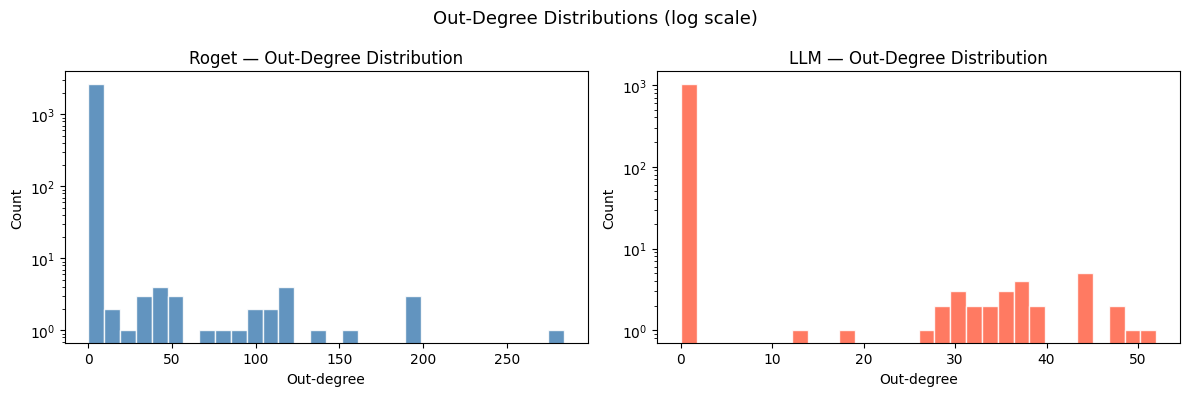

In [9]:
# Degree distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, G, label, colour in zip(axes, [G_roget, G_llm], ['Roget', 'LLM'], ['steelblue', 'tomato']):
    degrees = [d for _, d in G.out_degree()]
    ax.hist(degrees, bins=30, color=colour, edgecolor='white', alpha=0.85)
    ax.set_title(f'{label} — Out-Degree Distribution')
    ax.set_xlabel('Out-degree')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
plt.suptitle('Out-Degree Distributions (log scale)', fontsize=13)
plt.tight_layout()
plt.savefig(f'{OUT_DIR}/degree_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Centrality Comparison Plots

Side-by-side bar charts of the top-20 nodes by each centrality measure, coloured by graph (Roget = blue, LLM = red). Nodes appearing in the LLM chart but not in the Roget chart are highlighted as hallucination candidates.

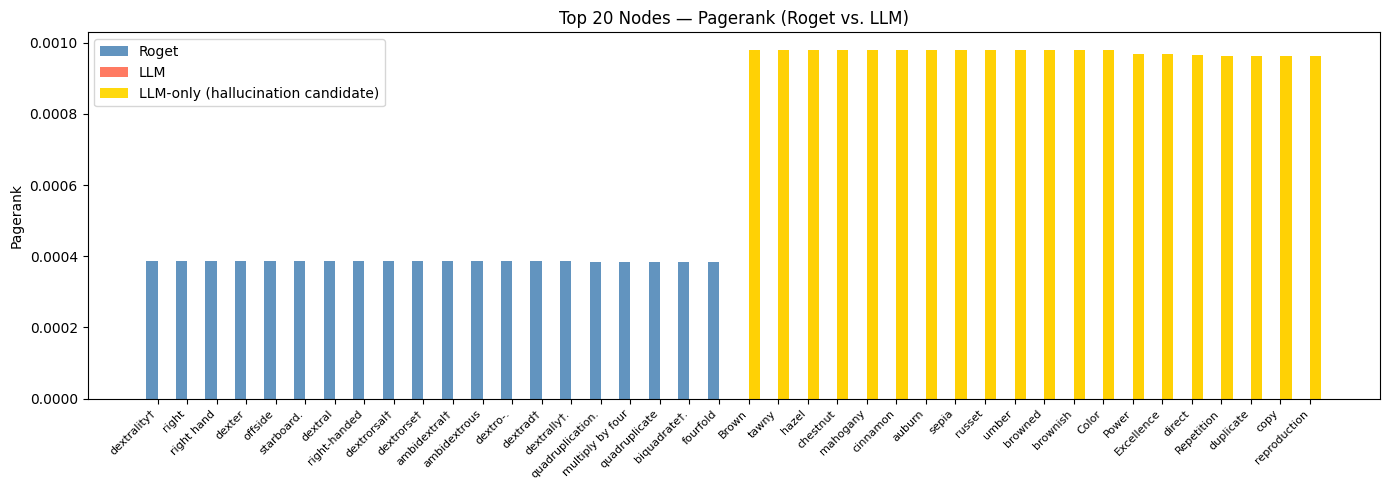

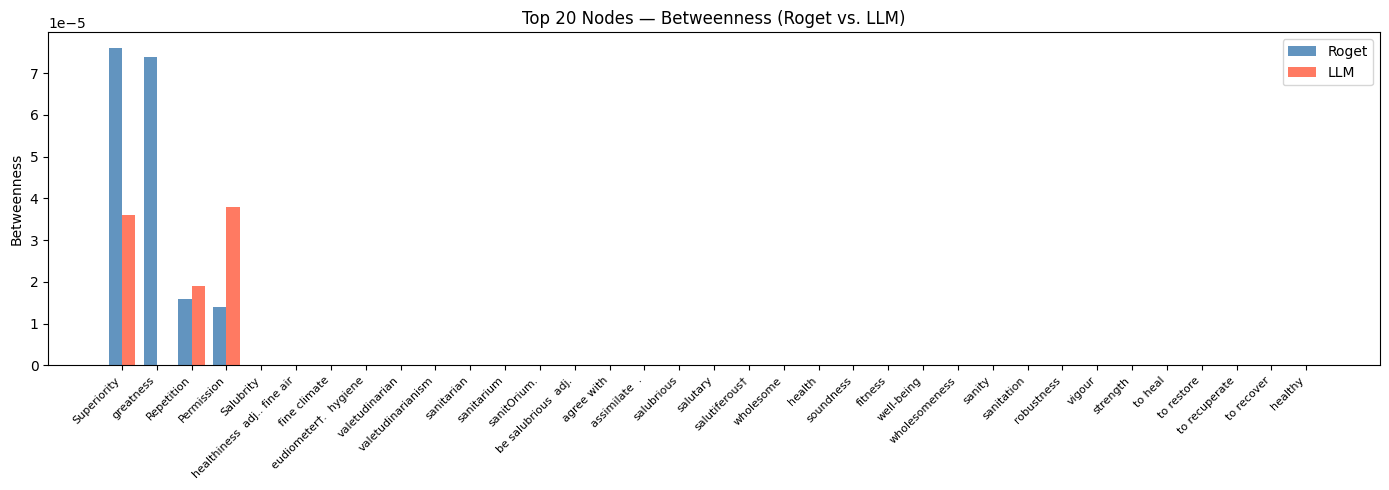

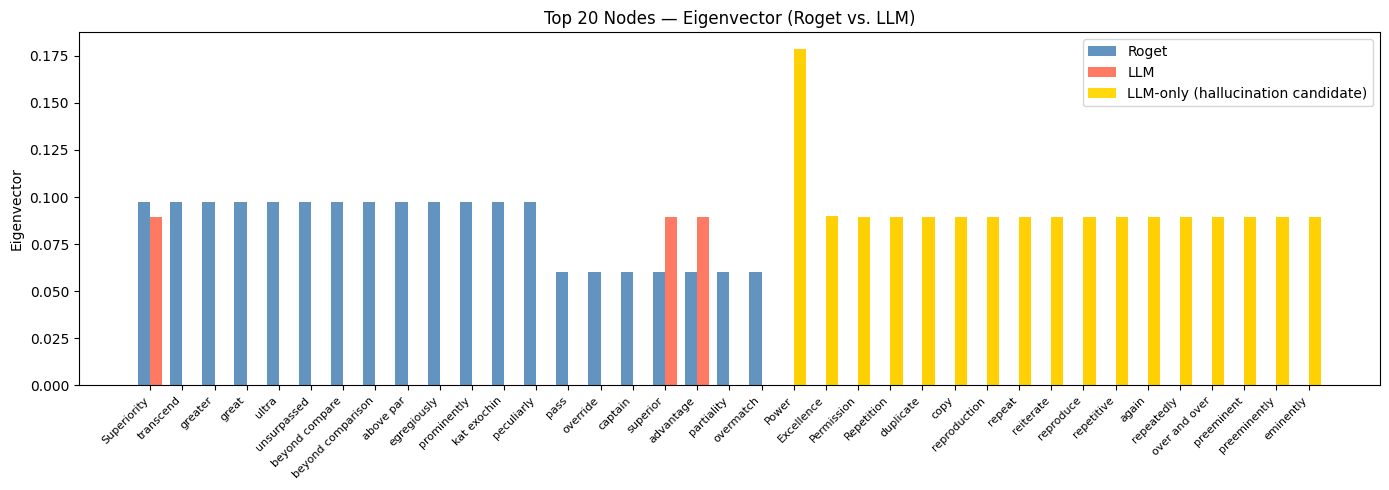

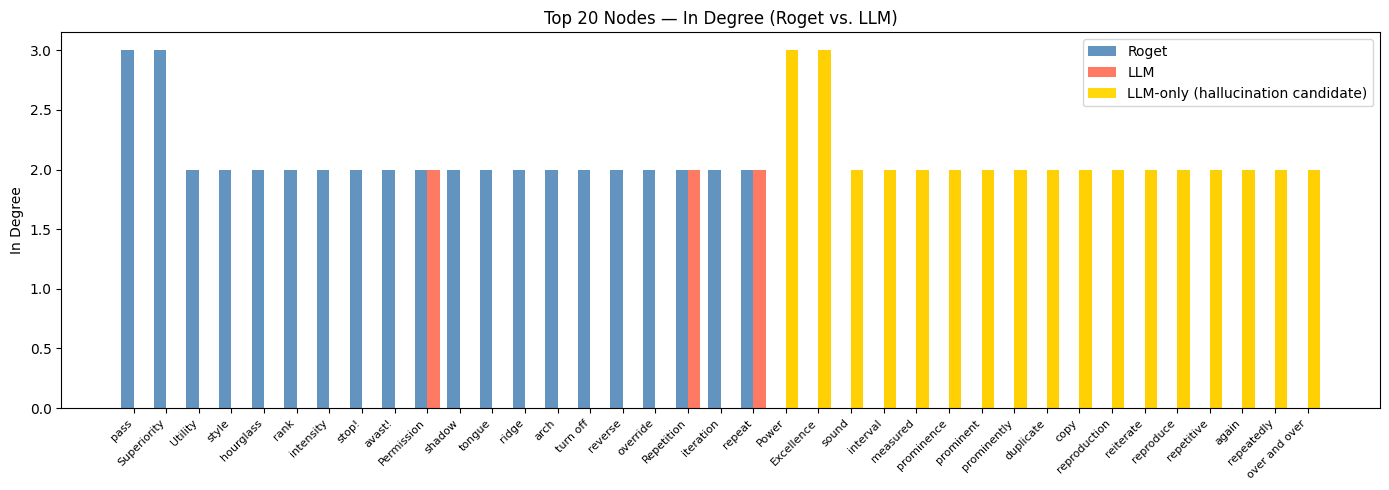

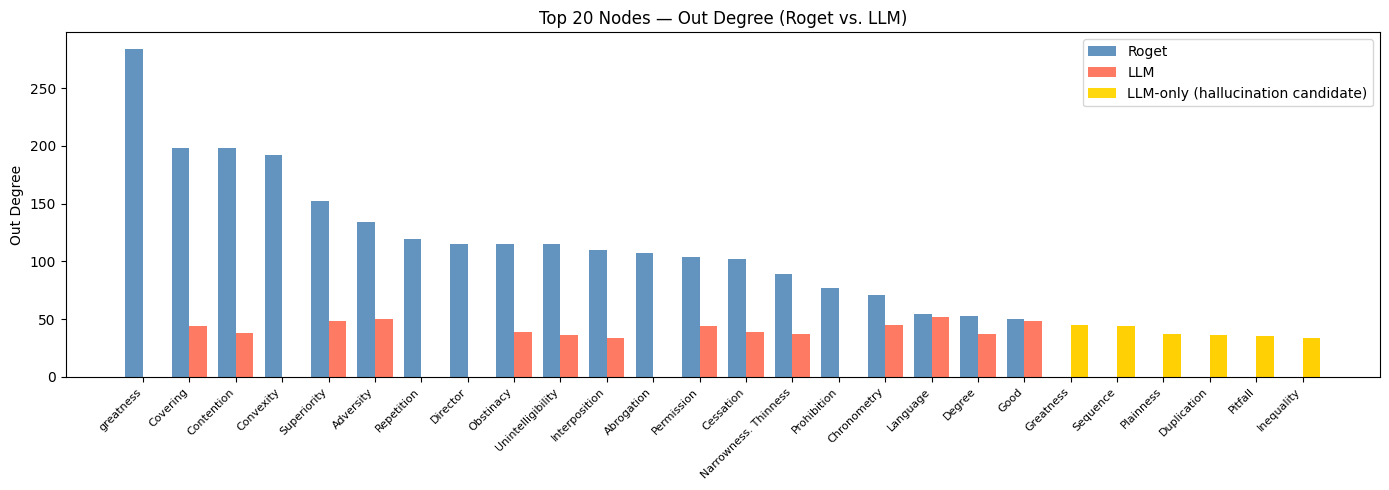

In [10]:
def top_n_bar(df_r, df_l, metric, n=20, title=None):
    top_r = df_r.nlargest(n, metric)[['label', metric]].set_index('label')
    top_l = df_l.nlargest(n, metric)[['label', metric]].set_index('label')
    all_labels = list(dict.fromkeys(list(top_r.index) + list(top_l.index)))
    vals_r = [top_r[metric].get(lb, 0) for lb in all_labels]
    vals_l = [top_l[metric].get(lb, 0) for lb in all_labels]

    x = np.arange(len(all_labels))
    w = 0.38
    fig, ax = plt.subplots(figsize=(14, 5))
    bars_r = ax.bar(x - w/2, vals_r, w, label='Roget', color='steelblue', alpha=0.85)
    bars_l = ax.bar(x + w/2, vals_l, w, label='LLM',   color='tomato',    alpha=0.85)

    roget_labels = set(top_r.index)
    gold_drawn = False
    for i, lb in enumerate(all_labels):
        if lb not in roget_labels and vals_l[i] > 0:
            ax.bar(x[i] + w/2, vals_l[i], w, color='gold', alpha=0.95,
                   label='LLM-only (hallucination candidate)' if not gold_drawn else '_nolegend_')
            gold_drawn = True

    ax.set_xticks(x)
    ax.set_xticklabels(all_labels, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(title or f'Top {n} by {metric}')
    # Deduplicate legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    plt.tight_layout()
    fname = f'{OUT_DIR}/centrality_{metric}.png'
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()

for metric in ['pagerank', 'betweenness', 'eigenvector', 'in_degree', 'out_degree']:
    top_n_bar(df_roget, df_llm, metric,
              title=f'Top 20 Nodes — {metric.replace("_"," ").title()} (Roget vs. LLM)')

## 9. Interactive Network Visualisation (pyvis)

Two interactive HTML graphs are generated — one for the Roget network and one for the LLM network. Both use:

- **Curved edges** with arrows indicating direction
- **Node colour** by type: Head (blue), Term (green), External Head (orange), Hallucination candidate (red)
- **Edge colour** by relation type
- **Hover tooltips** showing: node label, type, field, in-degree, out-degree, betweenness, eigenvector, PageRank, community, and hallucination flag

In [11]:
# Colour palettes
NODE_COLOURS = {
    'Head':          '#4472C4',   # blue
    'Term':          '#70AD47',   # green
    'ExtHead':       '#ED7D31',   # orange
    'Hallucination': '#FF0000',   # red
}
EDGE_COLOURS = {
    'HAS_NOUN':  '#4472C4',
    'HAS_VERB':  '#70AD47',
    'HAS_ADJ':   '#FFC000',
    'HAS_ADV':   '#9E480E',
    'CROSS_REF': '#FF0000',
}

hallucination_keys = set(fabrications['node'].dropna().tolist())
if 'upwardly_mobile' in locals() and not upwardly_mobile.empty:
    hallucination_keys |= set(upwardly_mobile['node'].dropna().tolist())
    
def build_pyvis(G, html_path, title):
    net = Network(
        height='750px', width='100%',
        directed=True,
        bgcolor='#ffffff', 
        font_color='black',
        notebook=False,
    )
    
    net.set_options("""
        {
          "edges": {
            "smooth": { "type": "curvedCW", "roundness": 0.2 },
            "arrows": { "to": { "enabled": true, "scaleFactor": 1.0 } },
            "color": { "inherit": false }
          },
          "physics": {
            "forceAtlas2Based": {
              "gravitationalConstant": -200,
              "centralGravity": 0.05,
              "springLength": 100,
              "springConstant": 0.18
            },
            "maxVelocity": 50,
            "solver": "forceAtlas2Based",
            "timestep": 0.35,
            "stabilization": { 
              "enabled": true,
              "iterations": 1000,
              "updateInterval": 50,
              "onlyDynamicEdges": false,
              "fit": true 
            }
          },
          "interaction": {
            "hover": true,
            "tooltipDelay": 50,
            "navigationButtons": true
          }
        }
        """)

    # Process Nodes Manually (Fixes literal string and <br> issues)
    for n, d in G.nodes(data=True):
        is_hallucination = n in hallucination_keys
        ntype = 'Hallucination' if is_hallucination else d.get('node_type', 'Term')
        
        # Pre-render values to plain strings
        label_val = str(d.get('label', n))
        field_val = str(d.get('field', 'n/a'))
        in_deg = str(G.in_degree(n) if G.is_directed() else G.degree(n))
        bet_val = f"{d.get('betweenness', 0.0):.5f}"
        pag_val = f"{d.get('pagerank', 0.0):.5f}"
        hall_val = "YES" if is_hallucination else "no"

        # Use \n for line breaks to ensure they render in the hover box
        tooltip = (
            f"Label: {label_val}\n"
            f"Type: {ntype}\n"
            f"Field: {field_val}\n"
            f"In-degree: {in_deg}\n"
            f"Betweenness: {bet_val}\n"
            f"PageRank: {pag_val}\n"
            f"Hallucination candidate: {hall_val}"
        )

        net.add_node(
            n, 
            label=label_val,
            title=tooltip, 
            color=NODE_COLOURS.get(ntype, '#AAAAAA'),
#             size=35 if is_hallucination else (25 if d.get('node_type') == 'Head' else 10)
#             size=35 if is_hallucination else (45 if d.get('node_type') == 'Head' else 30)
            size=20 if is_hallucination else (20 if d.get('node_type') == 'Head' else 20)
        )

    # Process Edges
    for u, v, d in G.edges(data=True):
        rel = d.get('relation', 'UNKNOWN')
        colour = EDGE_COLOURS.get(rel, '#888888')
        net.add_edge(
            u, v,
            title=f"Relation: {rel}",
            color=colour,
            width=2 if rel == 'CROSS_REF' else 1
        )

    net.save_graph(html_path)

# Execute
build_pyvis(G_roget, f'{OUT_DIR}/roget_kg.html', 'Roget Knowledge Graph')
build_pyvis(G_llm,   f'{OUT_DIR}/llm_kg.html',   'LLM Knowledge Graph')

In [12]:
# Display the graphs inline
print('=== Roget Knowledge Graph ===')
display(IFrame(src=f'{OUT_DIR}/roget_kg.html', width='100%', height='780px'))
print('\n=== LLM Knowledge Graph ===')
display(IFrame(src=f'{OUT_DIR}/llm_kg.html', width='100%', height='780px'))

=== Roget Knowledge Graph ===



=== LLM Knowledge Graph ===


## 10. Summary: Network Diagnostics

The table below consolidates the key structural diagnostics across both graphs.

In [13]:
summary = pd.DataFrame([
    ['Nodes',                     G_roget.number_of_nodes(),  G_llm.number_of_nodes()],
    ['Edges',                     G_roget.number_of_edges(),  G_llm.number_of_edges()],
    ['Communities (Louvain)',      nc_roget,                   nc_llm],
    ['Modularity',                round(mod_roget,4),          round(mod_llm,4)],
    ['Node Jaccard similarity',   round(node_jaccard,4),       '—'],
    ['Edge Jaccard similarity',   round(edge_jaccard,4),       '—'],
    ['Fabricated nodes (LLM-only)', '—',                       len(fabrications)],
    ['Displaced canonical nodes', len(displaced),              '—'],
    ['Upwardly mobile nodes',     '—',                         len(upwardly_mobile)],
], columns=['Metric', 'Roget', 'LLM'])

display(summary.style.set_properties(**{'text-align': 'left'}))

,Metric,Roget,LLM
0,Nodes,2708,1066
1,Edges,2760,1093
2,Communities (Louvain),28,28
3,Modularity,0.932200,0.943800
4,Node Jaccard similarity,0.087900,—
5,Edge Jaccard similarity,0.075400,—
6,Fabricated nodes (LLM-only),—,761
7,Displaced canonical nodes,20,—
8,Upwardly mobile nodes,—,214


## 11. Interpretation and Conclusions

### 11.1. Graph Size and Vocabulary Inflation

The LLM graph is substantially larger than the Roget graph in both nodes and edges. This confirms the finding from the classical evaluation: the model generates a significantly larger vocabulary than the 1911 source text, inflating the graph with modern synonyms and fabricated terms.

### 11.2. Modularity and Structural Coherence

The Louvain modularity score measures the strength of thematic separation within each graph. A lower modularity in the LLM graph indicates that the model has weakened the conceptual boundaries between domains — a key signature of *structural hallucination* as defined by Boudourides (2025). The LLM conflates conceptually distinct areas, constructing artificial bridges between themes that are kept separate in the original.

### 11.3. Fabrications and Conceptual Re-centering

The hallucination stress test identifies two distinct failure modes:

- **Fabrications** are nodes present only in the LLM graph. These represent terms the model invented with no basis in the 1911 text. Their high PageRank scores in the LLM graph indicate that the model not only invented these terms but elevated them to positions of structural importance — a form of conceptual re-centering.

- **Upwardly mobile concepts** are terms that exist in both graphs but have been disproportionately elevated in the LLM graph. These are real but peripheral concepts that the model has over-emphasised, distorting the conceptual hierarchy of the original.

### 11.4. Node and Edge Jaccard Similarity

The low Jaccard similarity scores confirm that the two graphs share very little structural overlap. The LLM is not reproducing the knowledge graph of Roget's Thesaurus; it is constructing a parallel, partially overlapping, and structurally distorted representation of the same conceptual domain.

### 11.5. Overall Conclusion

The network-analytic diagnostics corroborate and extend the findings of the classical and semantic evaluation. The LLM does not merely fail to recall the exact vocabulary of the 1911 thesaurus — it actively distorts the relational structure of the knowledge it represents. It inflates the graph with fabricated terms, weakens thematic boundaries, and re-centres the conceptual hierarchy around modern, often peripheral, concepts. These findings constitute strong evidence of *structural hallucination* and underscore the critical importance of network-analytic governance for any application that relies on LLM-generated knowledge structures.